In [1]:
import viz_functions
import os

postgres_user = os.environ.get('POSTGRES_USER')
postgres_password = os.environ.get('POSTGRES_PASSWORD')

## Setup Connection

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("PostgreSQL Connection with PySpark") \
    .config("spark.jars", "/visualization/postgresql-42.6.0.jar") \
    .getOrCreate()

url = "jdbc:postgresql://postgres:5432/airflow"

properties = {
    "user": postgres_user,
    "password": postgres_password,
    "driver": "org.postgresql.Driver"
}

## Load Tables

In [3]:
schema = 'papers'
tables = ['paper', 'author', 'journal', 'keyword']

for table in tables:
    table_name = f'{schema}.{table}'
    df = spark.read.jdbc(url, table_name, properties=properties)
    df.createOrReplaceTempView(table)
    print(f"\n########## {table} ##########")
    df.printSchema()
    df.show(2)
    print(f"Total rows: {df.count()}")


########## paper ##########
root
 |-- api_name: string (nullable = true)
 |-- api_id: string (nullable = true)
 |-- title: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- published_date: date (nullable = true)
 |-- publisher: string (nullable = true)

+--------+---------+--------------------+-------------------+--------------+--------------------+
|api_name|   api_id|               title|                doi|published_date|           publisher|
+--------+---------+--------------------+-------------------+--------------+--------------------+
|    core|137628615|Glucose Homeostas...|10.22028/d291-38686|    2023-01-06|Saarländische Uni...|
|    core|138044939|COMPASSION FOR TH...|                NaN|    2023-01-06|The Graduate Scho...|
+--------+---------+--------------------+-------------------+--------------+--------------------+
only showing top 2 rows

Total rows: 792650

########## author ##########
root
 |-- api_name: string (nullable = true)
 |-- api_id: string (nu

## Top n-grams Of Last Week

In [4]:
dates = spark.sql("SELECT DISTINCT week_start_date FROM keyword ORDER BY week_start_date DESC")
dates = dates.rdd.map(lambda row: row[0]).collect()
current_week = dates[0]
current_week

datetime.date(2023, 10, 30)

### Barplot

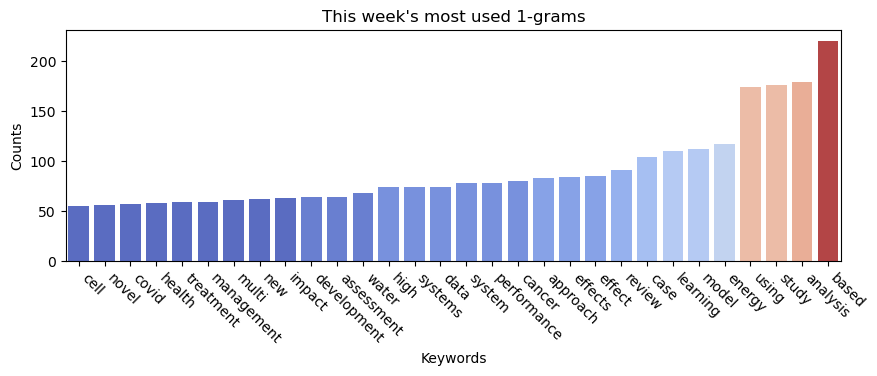

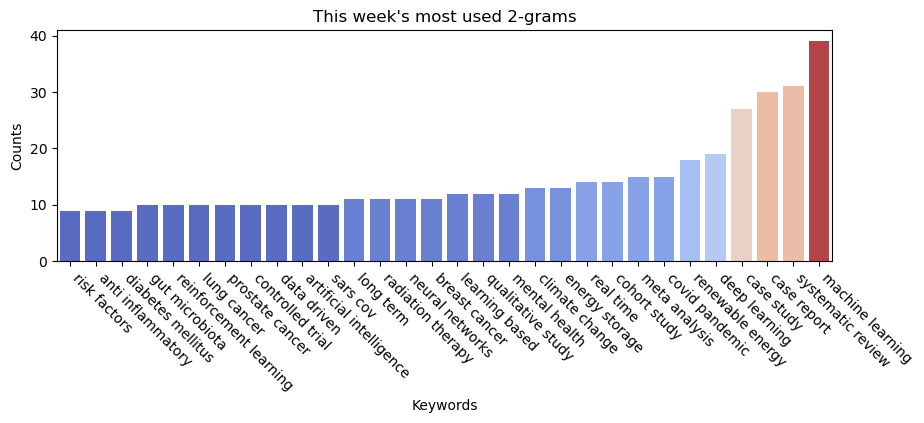

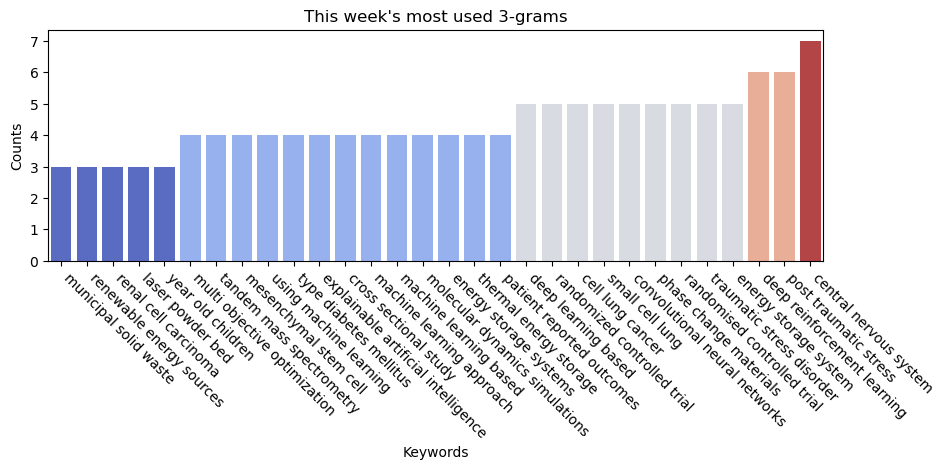

In [5]:
for n in [1,2,3]:
    query = f"""
                SELECT word, count
                FROM keyword
                WHERE week_start_date = '{current_week}'
                AND n = {n}
                ORDER BY count DESC
                LIMIT 30
    """
    viz_functions.barplot_ngrams(spark, query, x="word", y="count", title=f"This week's most used {n}-grams")

### WordCloud

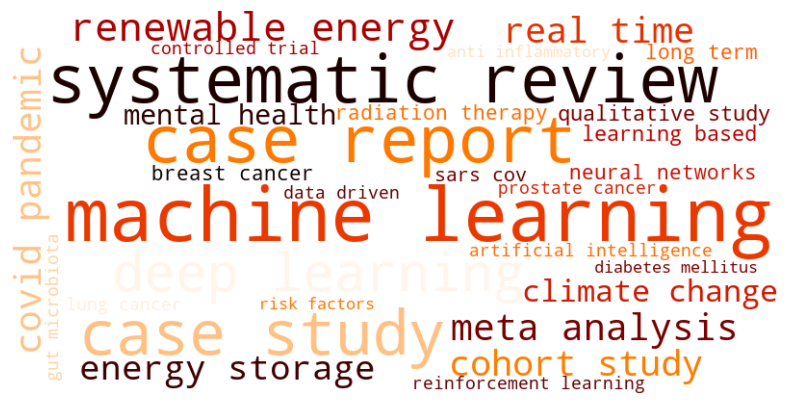

In [6]:
n = 2
query = f"""
            SELECT word, count
            FROM keyword
            WHERE week_start_date = '{current_week}'
            AND n = {n}
            ORDER BY count DESC
            LIMIT 30
"""
viz_functions.wordcloud_ngrams(spark, query)


## Keyword Evolution Through Time 

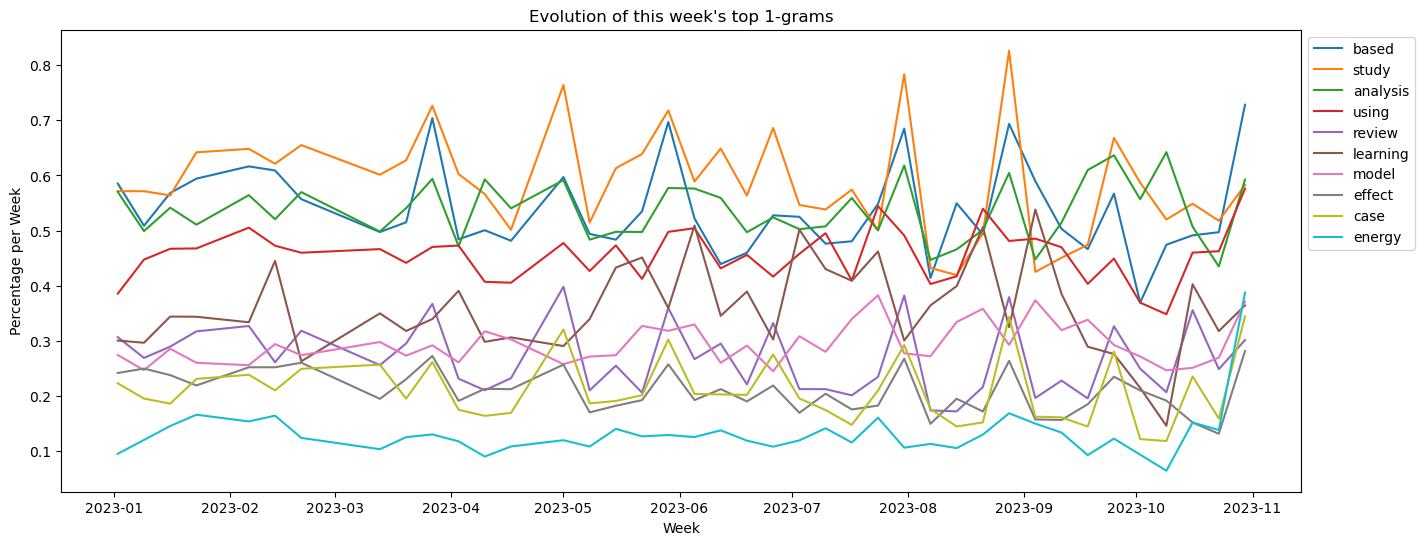

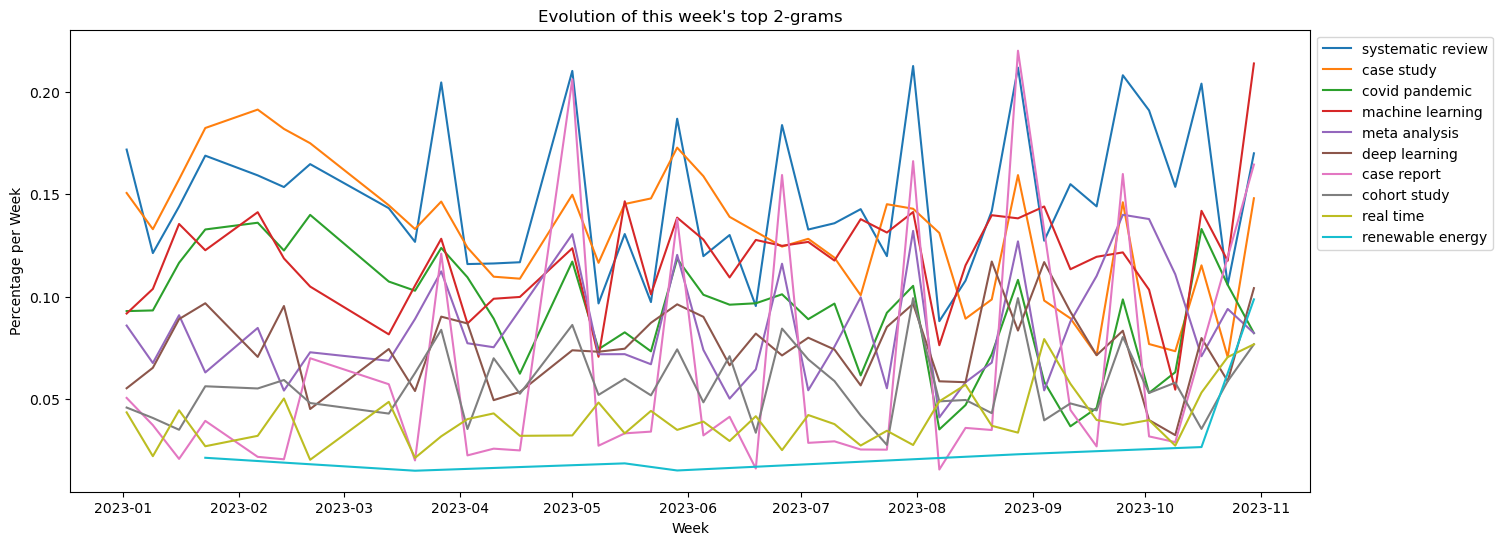

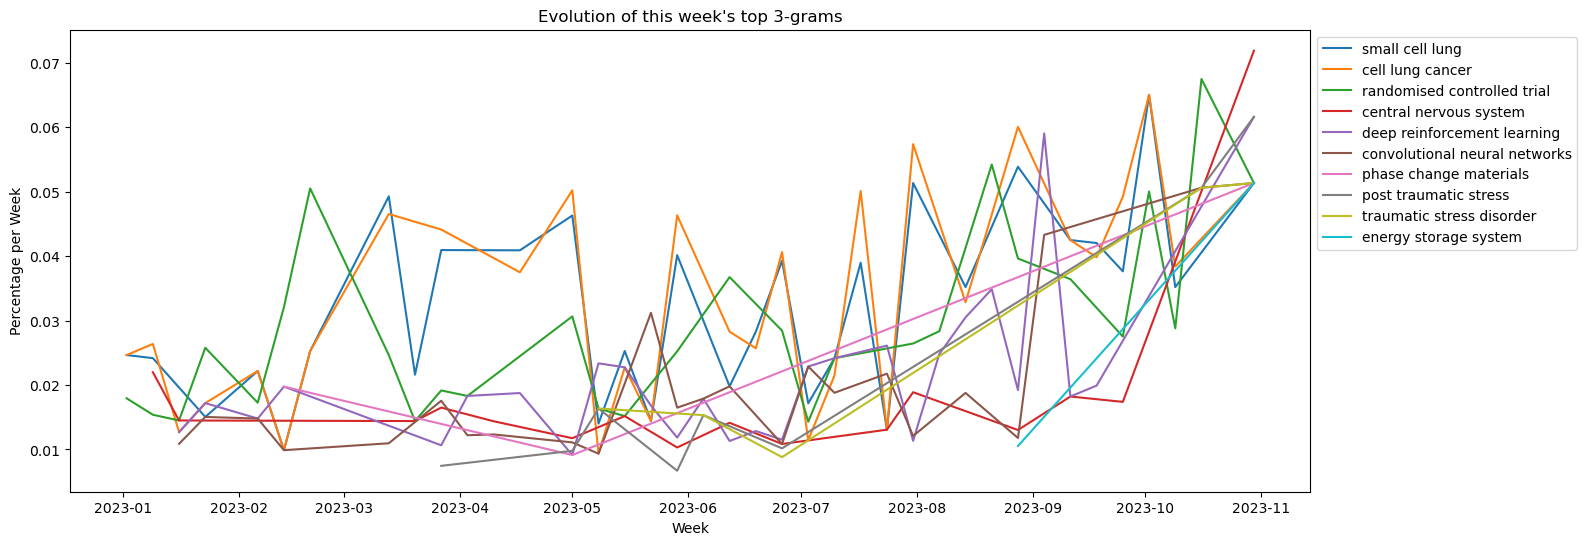

In [7]:
for n in [1, 2, 3]:
    query = f"""
                SELECT kw.week_start_date, kw.word, kw.week_percentage
                FROM keyword as kw 
                INNER JOIN
                (
                    SELECT word, count
                    FROM keyword
                    WHERE week_start_date = '{current_week}'
                    AND n = {n}
                    ORDER BY count DESC
                    LIMIT 10 ) as temp 
                ON kw.word = temp.word;
    """

    viz_functions.lineplot_ngrams(spark, query, x="week_start_date", y="week_percentage", hue="word", title=f"Evolution of this week's top {n}-grams")

## All Time Keyword Trends

### Barplot

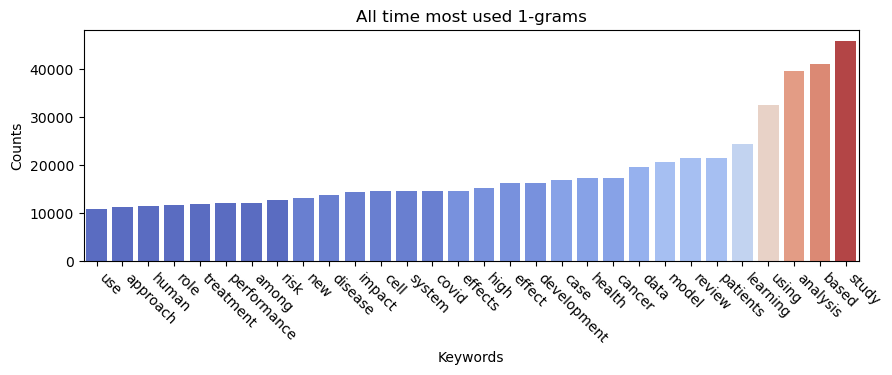

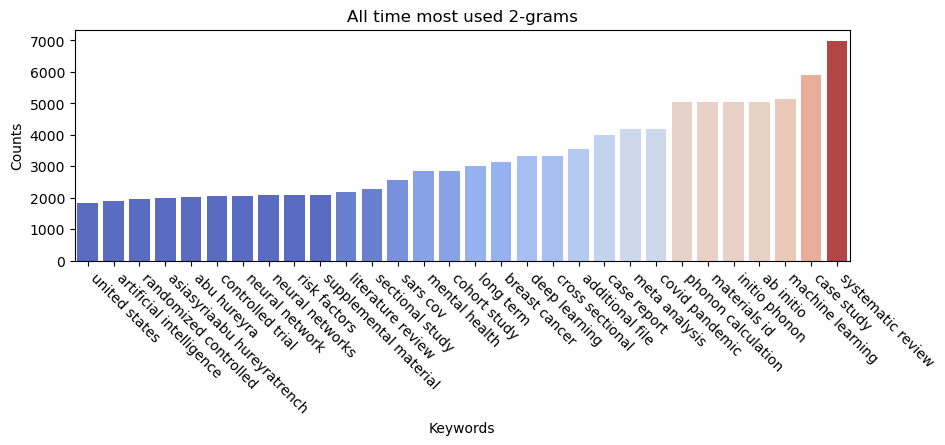

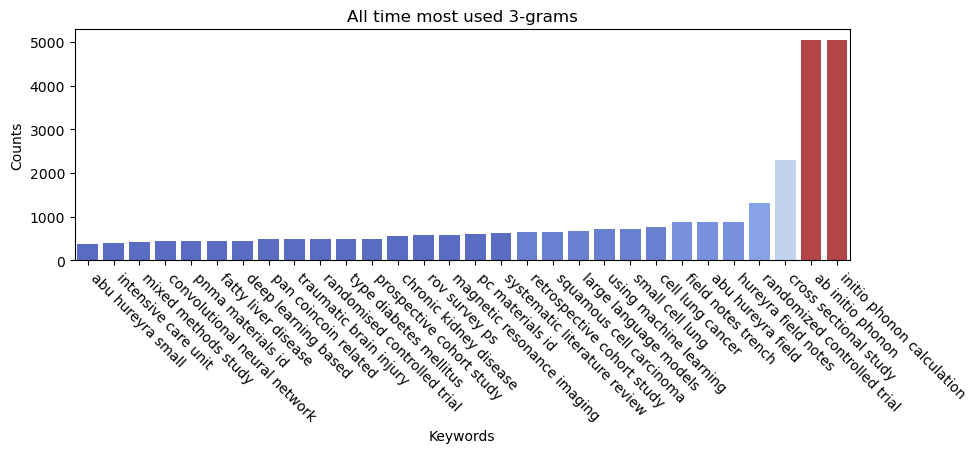

In [8]:
for n in [1,2,3]:
    query = f"""
                SELECT word, SUM(count) AS total_count 
                FROM keyword
                WHERE n = {n}
                GROUP BY word 
                ORDER BY total_count DESC 
                LIMIT 30;
            """
    viz_functions.barplot_ngrams(spark, query, x="word", y="total_count", title=f"All time most used {n}-grams")

### Lineplot

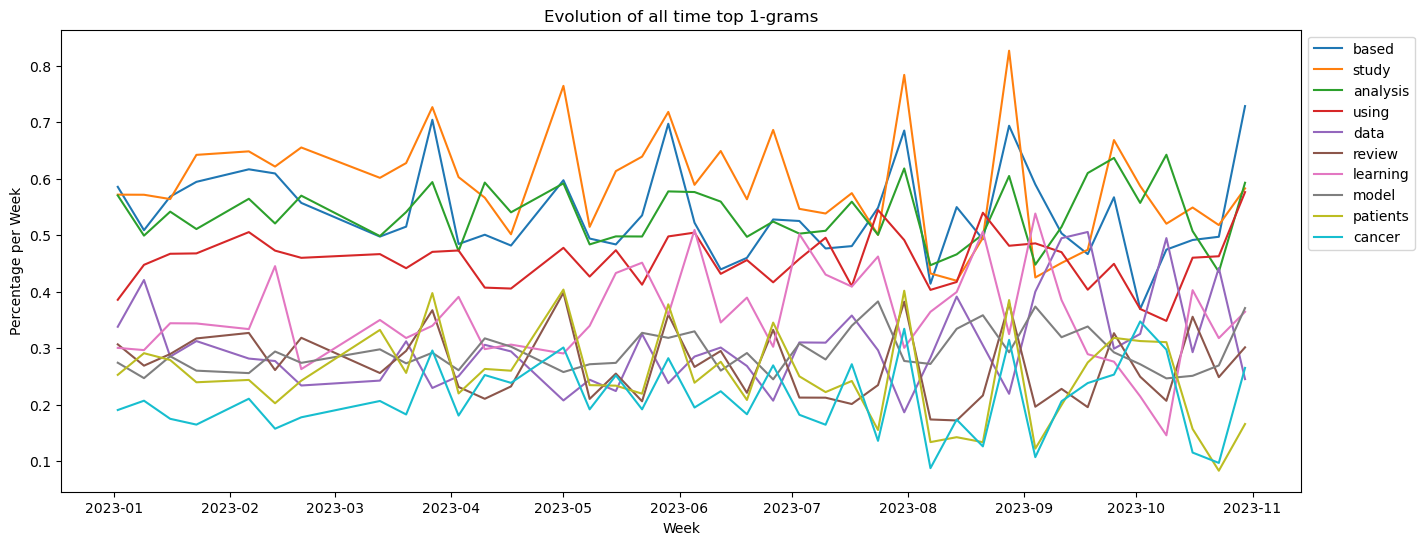

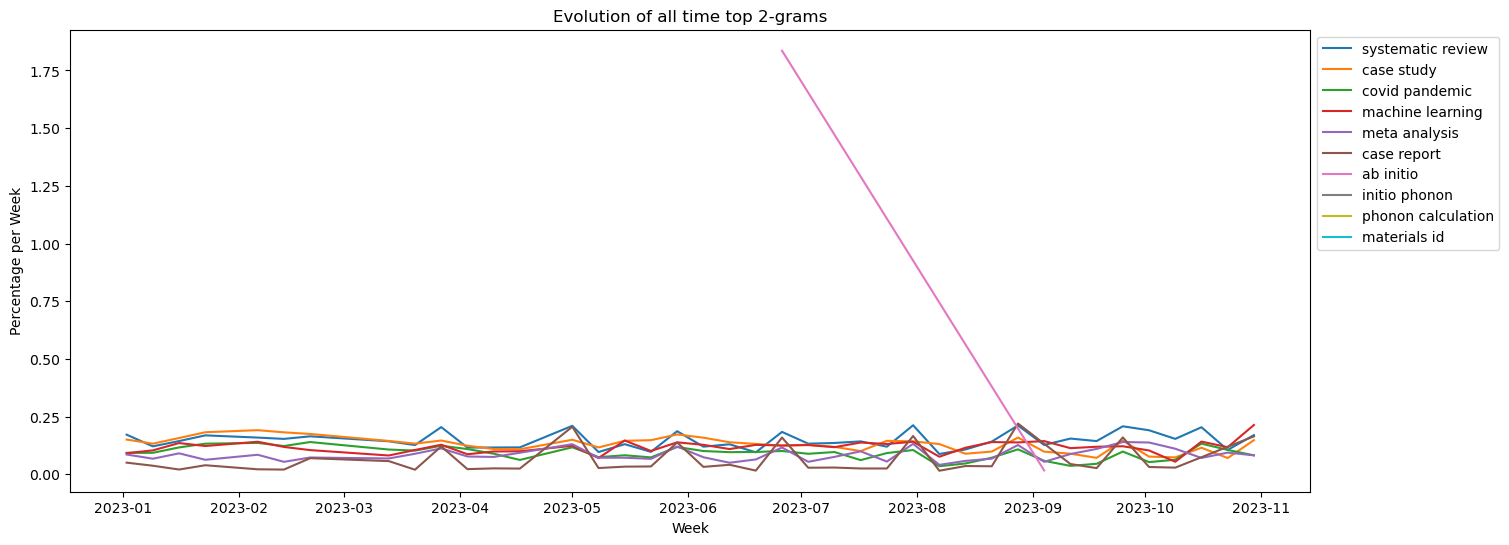

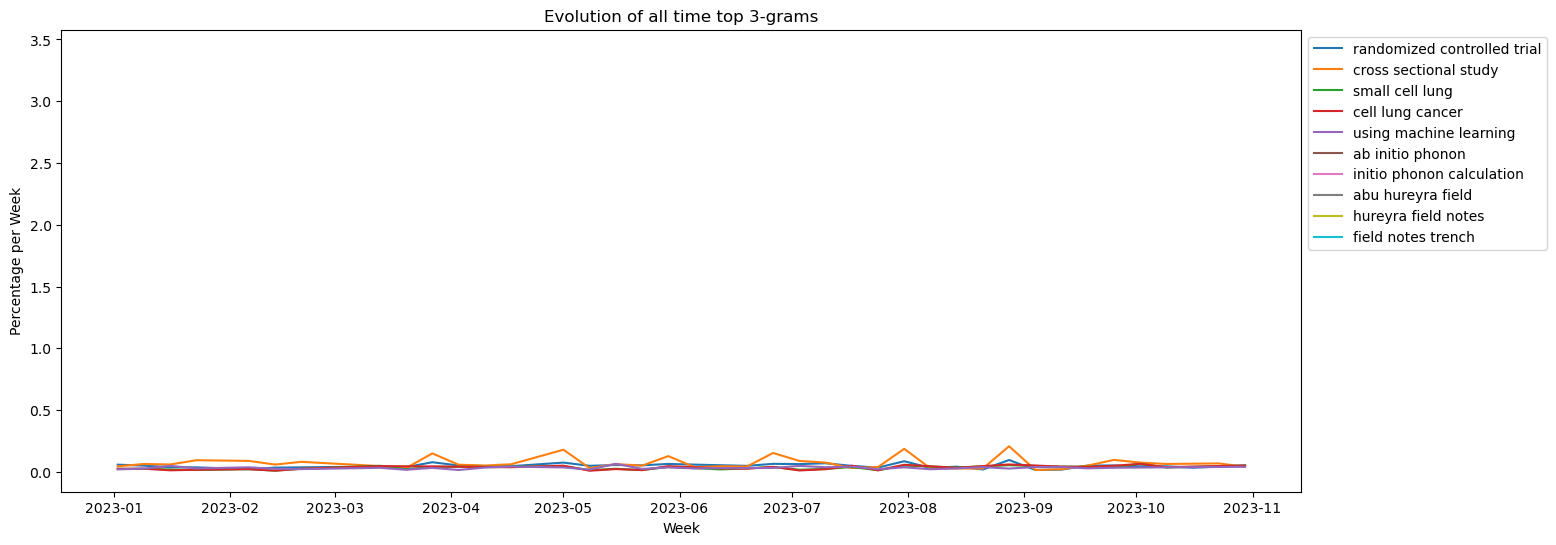

In [9]:
for n in [1, 2, 3]:
    query = f"""
                SELECT kw.week_start_date, kw.word, kw.week_percentage
                FROM keyword as kw 
                INNER JOIN
                (
                    SELECT word, SUM(count) AS total_count 
                    FROM keyword
                    WHERE n = {n}
                    GROUP BY word 
                    ORDER BY total_count DESC 
                    LIMIT 10
                ) as temp 
                ON kw.word = temp.word;
    """

    viz_functions.lineplot_ngrams(spark, query, x="week_start_date", y="week_percentage", hue="word", title=f"Evolution of all time top {n}-grams")

## Publications per Journal

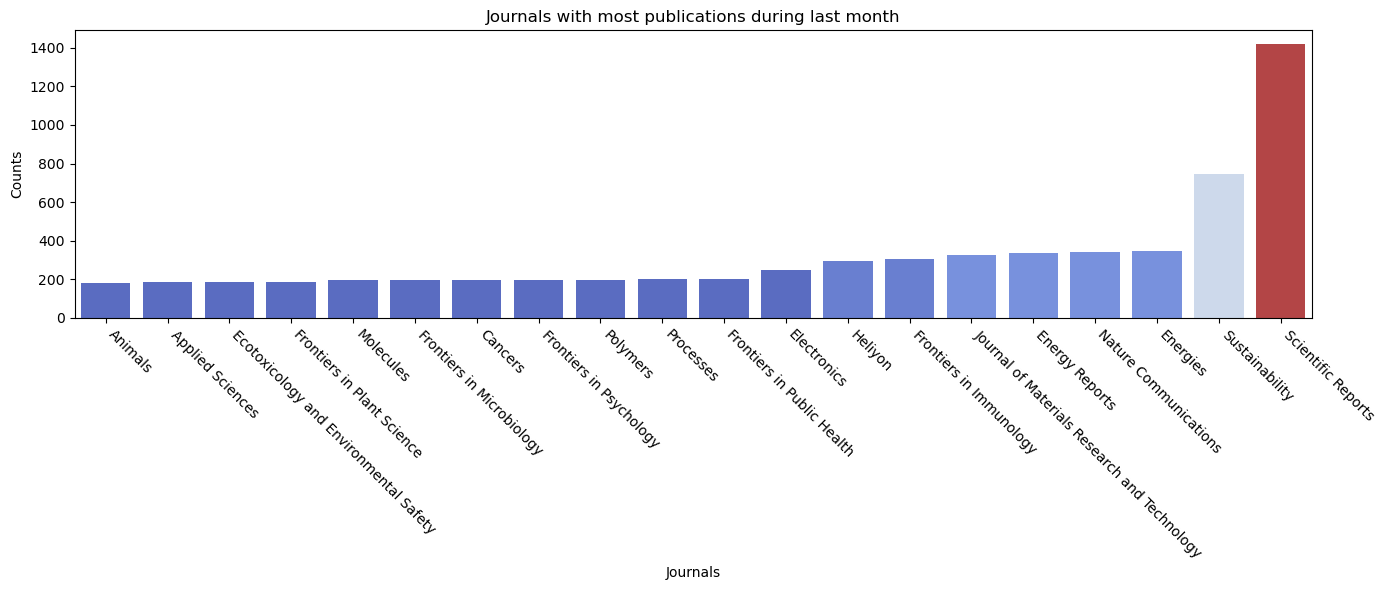

In [10]:
limit = 20
query = f"""
                SELECT j.name as Name, j.issn as ISSN, COUNT(*) as count
                FROM journal as j
                INNER JOIN (
                    SELECT api_name, api_id
                    FROM paper
                    WHERE EXTRACT(MONTH FROM published_date) = {current_week.month - 1}
                    AND EXTRACT(YEAR FROM published_date) = {current_week.year}
                ) as p
                ON (j.api_name, j.api_id) = (p.api_name, p.api_id)
                WHERE j.name IS NOT NULL
                AND j.name != 'NaN'
                GROUP BY j.name, j.issn
                ORDER BY count DESC
                LIMIT {limit};
            """
viz_functions.barplot_journals(spark, query, x='Name', y='count', title=f"Journals with most publications during last month")

## Publications per Author

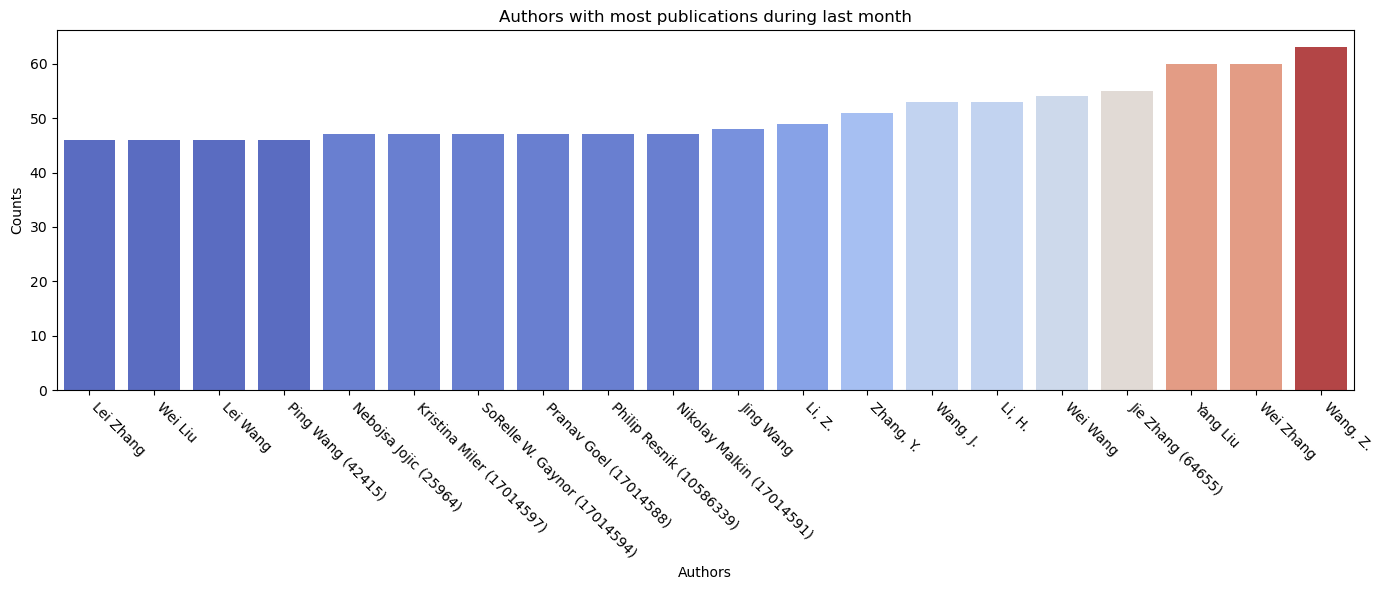

In [11]:
limit = 20
query = f"""
                SELECT a.name as Name, COUNT(*) as count
                FROM author as a
                INNER JOIN (
                    SELECT api_name, api_id
                    FROM paper
                    WHERE EXTRACT(MONTH FROM published_date) = {current_week.month - 1}
                    AND EXTRACT(YEAR FROM published_date) = {current_week.year}
                ) as p
                ON (a.api_name, a.api_id) = (p.api_name, p.api_id)
                WHERE a.name IS NOT NULL
                AND a.name != 'NaN'
                GROUP BY a.name
                ORDER BY count DESC
                LIMIT {limit};
            """
viz_functions.barplot_authors(spark , query, x='Name', y='count', title="Authors with most publications during last month")